# 1. Thư viện 

In [ ]:
!pip install scikit-multilearn regex underthesea vncorenlp neattext underthesea pyvi

In [77]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
from underthesea import word_tokenize, pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

import underthesea
from underthesea import word_tokenize, text_normalize, pos_tag
import neattext as nt
from tqdm import tqdm
import regex as re 
tqdm.pandas()

from collections import defaultdict

import pandas as pd
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
from pyvi import ViTokenizer

In [6]:
file_path = '/kaggle/input/articles/articles_training.tsv'
data = pd.read_csv(file_path, sep='\t')

# 2. Làm sạch dữ liệu

## 2.1 Tổng quan về dữ liệu thô

In [7]:
data.head()

,content,tags
0,"Bước vào trận đấu, Barcelona nhanh chóng tràn ...","La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,..."
1,Willian đi vào lịch sử bóng đá xứ samba. Với 1...,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ..."
2,Giải vô địch ná cao su thế giới năm 2024 đã di...,"ná cao su,giải vô địch,giải Ba,Thượng Hải,đồng..."
3,Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục..."
4,"Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề..."


In [8]:
data.describe()

,content,tags
count,99850,99850
unique,98760,98992
top,Mời quý vị và các bạn đón xem video dưới đây:,"xổ số,KQXS miền Nam,KQXSMN,KQXSMT,XSMB,miền Na..."
freq,115,26


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99850 entries, 0 to 99849
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  99850 non-null  object
 1   tags     99850 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


## 2.2 Loại bỏ dữ liệu trùng lặp

> Từ dữ liệu được miêu tả bên trên, thấy có (99850-98760=1090) dữ liệu content bị trùng, thực hiện loại bỏ trùng lặp.

In [11]:
data = data.drop_duplicates(subset=['content'])

print("Số dòng sau khi xóa trùng lặp content: ", len(data))

Số dòng sau khi xóa trùng lặp content:  98760


In [13]:
total_tags = data['tags'].str.split(',').apply(len).sum()
print(f"Tổng số nhãn chưa loại bỏ trùng lặp: {total_tags}")

Tổng số nhãn chưa loại bỏ trùng lặp: 1968390


## 2.3 Kiểm tra số lượng nhãn (tag) mỗi content

In [14]:
data['tags_list'] = data['tags'].apply(lambda x: x.split(','))
data['tags_length'] = data['tags_list'].apply(len)
data

,content,tags,tags_list,tags_length
0,"Bước vào trận đấu, Barcelona nhanh chóng tràn ...","La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,...","[La Liga, Sevilla, Olimpic Lluis Companys, đè ...",20
1,Willian đi vào lịch sử bóng đá xứ samba. Với 1...,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ...","[Estevao Willian, Neymar, giải VĐQG Brazil, Se...",20
2,Giải vô địch ná cao su thế giới năm 2024 đã di...,"ná cao su,giải vô địch,giải Ba,Thượng Hải,đồng...","[ná cao su, giải vô địch, giải Ba, Thượng Hải,...",19
3,Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục...","[đăng cai, Đại hội Thể thao châu Á, ASIAD, thể...",20
4,"Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề...","[toàn đoàn, lặn, Vũ Đặng Nhật Nam, Nguyễn Lê T...",20
...,...,...,...,...
99845,Tạo động lực phát triển nhanh và bền vững của ...,"Kỳ họp,Quốc hội,tư duy,Trần Thanh Mẫn,nguồn lự...","[Kỳ họp, Quốc hội, tư duy, Trần Thanh Mẫn, ngu...",20
99846,"Theo số liệu của Tổng cục Hải quan, trong 9 th...","cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư...","[cao su tự nhiên, cao su, ANRPC, Chứng khoán M...",20
99847,Mong có chiến lược ứng phó hiệu quả với thiên ...,"Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc...","[Kỳ họp thứ Tám, Trần Thanh Mẫn, ngắn gọn, Chủ...",20
99848,"Nhà chức trách xác định, Hoàng Văn Thảo có hàn...","Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ...","[Hoàng Văn Thảo, chạy án, Cục phó, giả danh, T...",20


In [15]:
tags_lengths = data['tags_list'].apply(len)
tags_lengths_list = tags_lengths.tolist()

print("Độ dài lớn nhất: " + str(max(tags_lengths_list)))
print("Độ dài nhỏ nhất: " + str(min(tags_lengths_list)))

Độ dài lớn nhất: 23
Độ dài nhỏ nhất: 3


In [16]:
std_dev = data['tags_length'].std()
variance = data['tags_length'].var()
mean_tags_length = data['tags_length'].mean()

print("Độ lệch chuẩn của tags_length: ", std_dev)
print("Phương sai của tags_length: ", variance)
print("Trung bình tags_length: ", mean_tags_length)

Độ lệch chuẩn của tags_length:  0.797519520487537
Phương sai của tags_length:  0.6360373855586711
Trung bình tags_length:  19.93104495747266


In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['tags_length'], kde=True, color='skyblue', bins=30)

# Thêm tiêu đề và nhãn cho trục
plt.title('Phân phối độ dài của các tag', fontsize=16)
plt.xlabel('Độ dài của tag', fontsize=12)
plt.ylabel('Tần suất', fontsize=12)

# Hiển thị biểu đồ
plt.show()

> Nhận thấy số lượng tag cho mỗi content gần sát với 20, thực hiện loại bỏ các dòng có số tag khác 20

In [18]:
data = data[(data['tags_length'] == 20)]
data

,content,tags,tags_list,tags_length
0,"Bước vào trận đấu, Barcelona nhanh chóng tràn ...","La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,...","[La Liga, Sevilla, Olimpic Lluis Companys, đè ...",20
1,Willian đi vào lịch sử bóng đá xứ samba. Với 1...,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ...","[Estevao Willian, Neymar, giải VĐQG Brazil, Se...",20
3,Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục...","[đăng cai, Đại hội Thể thao châu Á, ASIAD, thể...",20
4,"Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề...","[toàn đoàn, lặn, Vũ Đặng Nhật Nam, Nguyễn Lê T...",20
5,"Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...","Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa...","[Hồng Hà, Giàng Thị Dung, đua xe đạp, Lào Cai,...",20
...,...,...,...,...
99845,Tạo động lực phát triển nhanh và bền vững của ...,"Kỳ họp,Quốc hội,tư duy,Trần Thanh Mẫn,nguồn lự...","[Kỳ họp, Quốc hội, tư duy, Trần Thanh Mẫn, ngu...",20
99846,"Theo số liệu của Tổng cục Hải quan, trong 9 th...","cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư...","[cao su tự nhiên, cao su, ANRPC, Chứng khoán M...",20
99847,Mong có chiến lược ứng phó hiệu quả với thiên ...,"Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc...","[Kỳ họp thứ Tám, Trần Thanh Mẫn, ngắn gọn, Chủ...",20
99848,"Nhà chức trách xác định, Hoàng Văn Thảo có hàn...","Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ...","[Hoàng Văn Thảo, chạy án, Cục phó, giả danh, T...",20


> Dữ liệu giảm khoảng 2000 dòng

## 2.4 Kiểm tra số lượng từ mỗi content và tags

In [19]:
data['Content_Word_Count'] = data['content'].apply(lambda x: len(x.split()))
data['Tags_Word_Count'] = data['tags'].apply(lambda x: sum(len(tag.split()) for tag in x.split(',')))

data[['content', 'Content_Word_Count', 'tags', 'Tags_Word_Count']]

/tmp/ipykernel_24/2367217539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Content_Word_Count'] = data['content'].apply(lambda x: len(x.split()))
/tmp/ipykernel_24/2367217539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tags_Word_Count'] = data['tags'].apply(lambda x: sum(len(tag.split()) for tag in x.split(',')))


,content,Content_Word_Count,tags,Tags_Word_Count
0,"Bước vào trận đấu, Barcelona nhanh chóng tràn ...",217,"La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,...",40
1,Willian đi vào lịch sử bóng đá xứ samba. Với 1...,314,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ...",41
3,Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...,903,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục...",72
4,"Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...",364,"toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề...",50
5,"Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...",997,"Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa...",56
...,...,...,...,...
99845,Tạo động lực phát triển nhanh và bền vững của ...,1136,"Kỳ họp,Quốc hội,tư duy,Trần Thanh Mẫn,nguồn lự...",53
99846,"Theo số liệu của Tổng cục Hải quan, trong 9 th...",647,"cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư...",49
99847,Mong có chiến lược ứng phó hiệu quả với thiên ...,1360,"Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc...",57
99848,"Nhà chức trách xác định, Hoàng Văn Thảo có hàn...",353,"Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ...",53


In [20]:
content_word_lengths = data['Content_Word_Count']
content_word_lengths = content_word_lengths.tolist()
print("Độ dài từ trong Content lớn nhất: " + str(max(content_word_lengths)))
print("Độ dài từ trong Content nhỏ nhất: " + str(min(content_word_lengths)))

Độ dài từ trong Content lớn nhất: 24067
Độ dài từ trong Content nhỏ nhất: 1


In [21]:
std_dev = data['Content_Word_Count'].std()
variance = data['Content_Word_Count'].var()
mean_tags_length = data['Content_Word_Count'].mean()

print("Độ lệch chuẩn của Content_Word_Count: ", std_dev)
print("Phương sai của Content_Word_Count: ", variance)
print("Trung bình Content_Word_Count: ", mean_tags_length)

Độ lệch chuẩn của Content_Word_Count:  452.62819977471423
Phương sai của Content_Word_Count:  204872.2872312986
Trung bình Content_Word_Count:  631.8028957608875


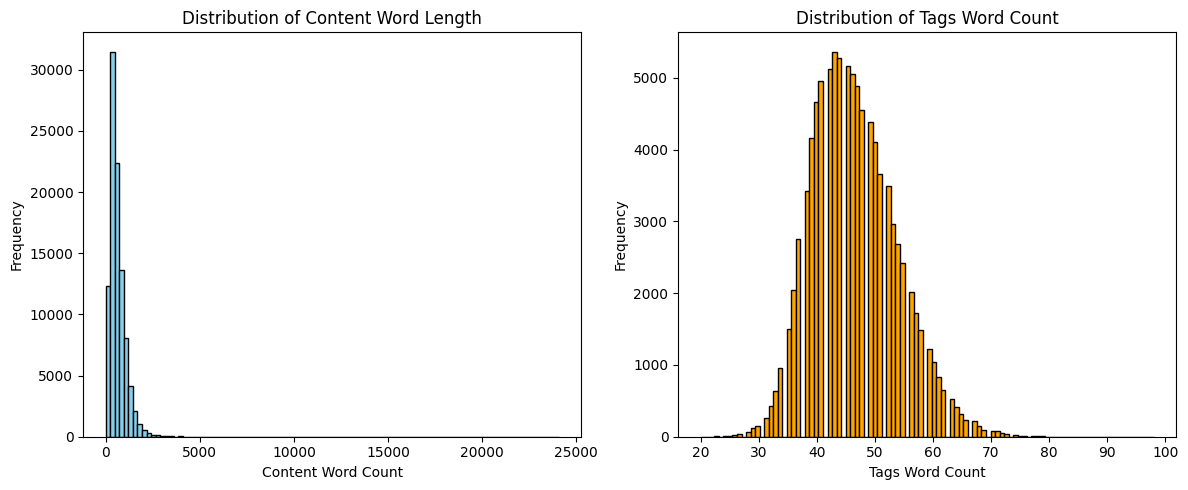

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data['Content_Word_Count'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Content Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Content Word Length')

plt.subplot(1, 2, 2)
plt.hist(data['Tags_Word_Count'], bins=100, color='orange', edgecolor='black')
plt.xlabel('Tags Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Tags Word Count')

plt.tight_layout()
plt.show()

> * Độ dài đếm theo từ của trường tags tuân theo phân bố chuẩn
> * Độ dài đếm theo từ của trường content đang bị lệch do có nhiễu
> => Tiến hành loại bỏ nhiễu

In [24]:
data = data[~((data['Content_Word_Count'] > 3000) | (data['Content_Word_Count'] < 70))]
data.shape[0]

95811

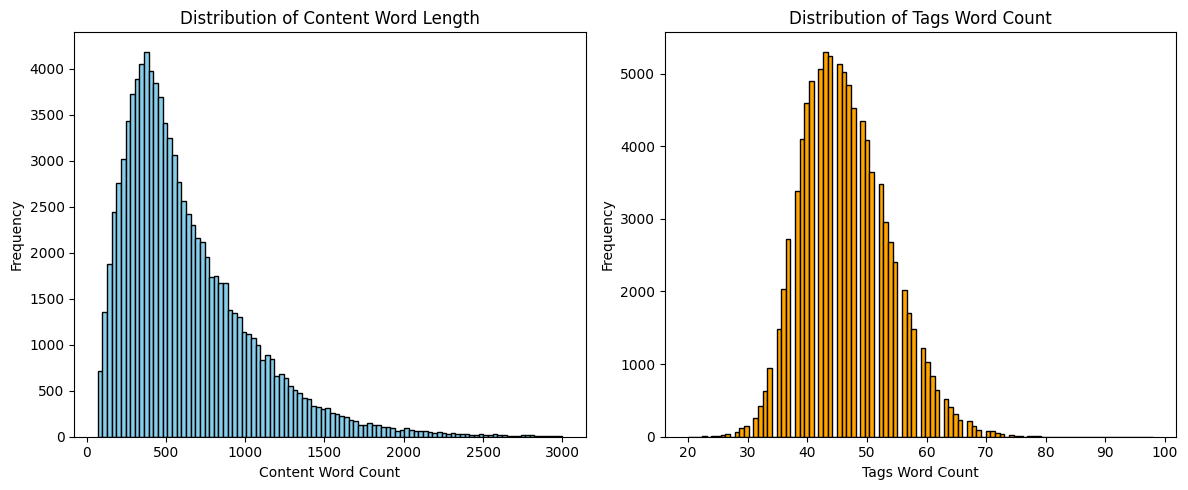

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data['Content_Word_Count'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Content Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Content Word Length')

plt.subplot(1, 2, 2)
plt.hist(data['Tags_Word_Count'], bins=100, color='orange', edgecolor='black')
plt.xlabel('Tags Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Tags Word Count')

plt.tight_layout()
plt.show()

In [26]:
std_dev = data['Content_Word_Count'].std()
variance = data['Content_Word_Count'].var()
mean_tags_length = data['Content_Word_Count'].mean()

print("Độ lệch chuẩn của Content_Word_Count: ", std_dev)
print("Phương sai của Content_Word_Count: ", variance)
print("Trung bình Content_Word_Count: ", mean_tags_length)

Độ lệch chuẩn của Content_Word_Count:  404.7908469101427
Phương sai của Content_Word_Count:  163855.6297422306
Trung bình Content_Word_Count:  627.1644278840635


## 2.5 Loại bỏ stopwords

Thực hiện tìm trong các nhãn xem xuất hiện stopword không?
* Nếu có thực hiện loại bỏ stopword đó ra khỏi danh sách stopwords ban đầu.
* Tiếp đó, thực hiện loại bỏ stopwords trong phần content

In [27]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = file.readlines()
   
    stopwords = set([word.strip() for word in stopwords])
    return stopwords

stopwords = load_stopwords('/kaggle/input/mydataset/vietnamese-stopwords.txt')

def check_stopwords(tag_text, stopwords_set):
    words = tag_text.split()
    return any(word in stopwords_set for word in words)

data['has_stopword'] = data['tags'].apply(lambda x: check_stopwords(x, stopwords))

In [28]:
num_rows_with_stopwords = data['has_stopword'].sum()
print(f"Số dòng chứa stopwords trong cột 'tags': {num_rows_with_stopwords}")

rows_with_stopwords = data[data['has_stopword']]
print("Các dòng chứa stopwords:")
print(rows_with_stopwords['tags'])

Số dòng chứa stopwords trong cột 'tags': 54727
Các dòng chứa stopwords:
0        La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,...
3        đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục...
8        Press Cup 2024,giải bóng đá,cơ quan báo chí,TP...
11       Akram Afif,Titan Sports,Afif,Son Heung-min,Sou...
16       Ngọc Trinh,tóc giả,mái tóc,sai lầm,flex,cưa sừ...
                               ...                        
99844    mũ bảo hiểm,xe đạp điện,giữ trọn,an toàn giao ...
99846    cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư...
99847    Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc...
99848    Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ...
99849    đấu thầu,vật tư,hóa chất,thiết bị y tế,thông t...
Name: tags, Length: 54727, dtype: object


In [29]:
# Hàm tìm stopwords trong tag_text
def find_stopwords(tag_text, stopwords_set):
    # Tách các từ trong tag dựa trên dấu phẩy
    words = [word.strip() for word in tag_text.split(',')]
    # Tìm các stopword trong words
    found = [word for word in words if word in stopwords_set]
    return found

data['found_stopwords'] = data['tags'].apply(lambda x: find_stopwords(x, stopwords))

data['has_stopword'] = data['found_stopwords'].apply(lambda x: len(x) > 0)

In [30]:
# Lọc các dòng chứa stopwords
rows_with_stopwords = data[data['has_stopword']]

tags_stopwords = []
for index, row in rows_with_stopwords.iterrows():
    tags = row['tags']
    found = row['found_stopwords']
    tags_stopwords.append(found)

In [ ]:
tags_stopwords_list = [item for sublist in tags_stopwords for item in sublist]
tags_stopwords_list = set(tags_stopwords_list)
print(tags_stopwords_list)

In [32]:
len(tags_stopwords_list)

810

In [33]:
len(stopwords)

1942

In [34]:
# Thực hiện loại bỏ stopword có trong tags
stopwords = stopwords - tags_stopwords_list
len(stopwords)

1132

In [35]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]


def preprocess_text_vietnamese_with_stopwords(text):
    
    tokens = underthesea.word_tokenize(text)
    
    tokens_without_stopwords = remove_stopwords(tokens)
    
    text_processed = ' '.join(tokens_without_stopwords)
    
    return text_processed

In [36]:
def clean_special_characters(text):        
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'http[s]?://\S+', '', text)
    
    return text

In [37]:
data['clean_content'] = data['content'].apply(preprocess_text_vietnamese_with_stopwords)
data['clean_content'] = data['clean_content'].apply(clean_special_characters)
print(data[['content', 'clean_content']])

                                                 content  \
0      Bước vào trận đấu, Barcelona nhanh chóng tràn ...   
1      Willian đi vào lịch sử bóng đá xứ samba. Với 1...   
3      Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...   
4      Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...   
5      Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...   
...                                                  ...   
99845  Tạo động lực phát triển nhanh và bền vững của ...   
99846  Theo số liệu của Tổng cục Hải quan, trong 9 th...   
99847  Mong có chiến lược ứng phó hiệu quả với thiên ...   
99848  Nhà chức trách xác định, Hoàng Văn Thảo có hàn...   
99849  Trong 6 tháng đầu năm 2024, Sở Y tế thành phố ...   

                                           clean_content  
0      Bước trận đấu , Barcelona nhanh chóng tràn tấn...  
1      Willian đi lịch sử bóng đá xứ samba . Với 1 bà...  
3      Mục tiêu Phó Thủ tướng Chính phủ Lê Thành Long...  
4      Ngày 20-10 , Giải bơi lặn vô địch qu

In [40]:
data['content'].iloc[0]

'Bước vào trận đấu, Barcelona nhanh chóng tràn lên tấn công nhưng vấp phải sự kháng cự quyết liệt của Sevilla. Bước ngoặt đến ở phút 22, Raphinha bị phạm lỗi trong vòng cấm và trọng tài đã cho Barcelona hưởng quả phạt đền. Trên chấm 11m, Lewandowski đã ghi bàn mở tỷ số cho Barcelona. Đến phút 28, Pedri đã có bàn nhân đôi cách biệt cho đội chủ nhà trước khi Lewandowski hoàn tất cú đúp cho riêng mình ở phút 39. Hiệp 1 khép lại với tỉ số 3-0 nghiêng về Barcelona. Sang hiệp 2, các chân sút của Barcelona liên tiếp bắn phá khung thành của Sevilla nhưng rất tiếc đều rơi vào thế việt vị. Tuy nhiên, chỉ trong vòng ít phút từ phút 82 đến 88, các khán giả có mặt trên sân Olimpic Lluis Companys đã được chứng kiến tới 3 bàn thắng. Cầu thủ vào sân thay người bên phía Barcelona là Torre lập cú đúp, xen giữa là bàn thắng danh dự của Idumbo bên phía Sevilla. Chung cuộc, Barca thắng Sevilal với tỷ số 5-1. Như vậy, đoàn quân của HLV Hansi Flick củng cố vị trí dẫn đầu trên bảng xếp hạng La Liga, duy trì k

In [41]:
data['clean_content'].iloc[0]

'Bước trận đấu , Barcelona nhanh chóng tràn tấn công vấp kháng cự quyết liệt Sevilla . Bước ngoặt phút 22 , Raphinha phạm lỗi vòng cấm trọng tài Barcelona hưởng phạt đền . Trên chấm 11 m , Lewandowski ghi bàn tỷ số Barcelona . Đến phút 28 , Pedri bàn nhân đôi cách biệt đội chủ Lewandowski hoàn tất cú đúp phút 39 . Hiệp 1 khép tỉ số 3-0 nghiêng Barcelona . Sang hiệp 2 , chân sút Barcelona liên tiếp bắn phá khung thành Sevilla tiếc rơi việt vị . Tuy nhiên , vòng phút phút 82 88 , khán giả có mặt sân Olimpic Lluis Companys chứng kiến 3 bàn thắng . Cầu thủ sân thay Barcelona Torre lập cú đúp , xen bàn thắng danh dự Idumbo Sevilla . Chung cuộc , Barca thắng Sevilal tỷ số 5-1 . Như vậy , đoàn quân HLV Hansi Flick củng cố vị trí dẫn đầu bảng xếp hạng La Liga , duy trì khoảng cách 3 đại kình địch Real Madrid .'

# 3. Khám phá dữ liệu (EDA)

## 3.1 Tags

### 3.1.1 Đếm tần suất và loại từ cho từng nhãn (tag)

In [42]:
# Đếm tần suất các nhãn  
tag_counter = Counter()
data['tags'].apply(lambda tags: tag_counter.update(tags.split(',')))

tags_df = pd.DataFrame(tag_counter.items(), columns=['Tag', 'Frequency'])

tags_df = tags_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

tags_df

,Tag,Frequency
0,năm,7321
1,Israel,2682
2,Liên bang Nga,2358
3,TP.HCM,2246
4,bão,2096
...,...,...
160678,NOTEBOOKCHECK,1
160679,Báo Nhân dân nhân dịp,1
160680,Zalo SOS,1
160681,Tổng đài 1022 Đà Nẵng,1


In [43]:
# Hàm để tách từ và phân tích từ loại cho từng tag
def analyze_tag_underthesea(tag):
    tokenized_tag = word_tokenize(tag, format="text")  
    pos_tags = pos_tag(tokenized_tag)  
    return pos_tags

tags_df['POS_Types'] = tags_df['Tag'].apply(analyze_tag_underthesea)

In [44]:
tags_df[0:100]

,Tag,Frequency,POS_Types
0,năm,7321,"[(năm, M)]"
1,Israel,2682,"[(Israel, Np)]"
2,Liên bang Nga,2358,"[(Liên_bang, Np), (Nga, Np)]"
3,TP.HCM,2246,"[(TP.HCM, Np)]"
4,bão,2096,"[(bão, N)]"
...,...,...,...
95,Đồng Nai,646,"[(Đồng_Nai, Np)]"
96,du khách,646,"[(du_khách, M)]"
97,bão Trà Mi,643,"[(bão, N), (Trà_Mi, Np)]"
98,TTXVN,637,"[(TTXVN, Np)]"


In [45]:
tags1 = tags_df[((tags_df['Frequency'] < 2000))]
tags1['Frequency'].sum()

1899517

> Số nhãn có tần suất xuất hiện < 2000 chiếm phần đa tổng số nhãn

In [47]:
# Tính số hàng có Frequency < 500
num_freq_1 = tags_df[tags_df['Frequency'] < 500]['Frequency'].sum()

# Tính tổng số xuất hiện
total_freq = tags_df['Frequency'].sum()

ratio = num_freq_1 / total_freq

print(f"Số lần xuất hiện 'Frequency' < 500: {num_freq_1}")
print(f"Tổng số xuất hiện: {total_freq}")
print(f"Tỷ lệ 'Frequency' < 500 trên tổng số xuất hiện: {ratio:.4f} ({ratio*100:.2f}%)")

Số lần xuất hiện 'Frequency' < 500: 1765676
Tổng số xuất hiện: 1916220
Tỷ lệ 'Frequency' < 500 trên tổng số xuất hiện: 0.9214 (92.14%)


In [48]:
# Phân loại thành các nhóm có tần suất xuất hiện như sau:
bins = [0, 10, 100, tags_df['Frequency'].max()]
labels = ['1-10', '11-100', '>100']

tags_df['Frequency_Group'] = pd.cut(tags_df['Frequency'], bins=bins, labels=labels, right=True)

tags_df[['Tag', 'Frequency', 'Frequency_Group']]

,Tag,Frequency,Frequency_Group
0,năm,7321,>100
1,Israel,2682,>100
2,Liên bang Nga,2358,>100
3,TP.HCM,2246,>100
4,bão,2096,>100
...,...,...,...
160678,NOTEBOOKCHECK,1,1-10
160679,Báo Nhân dân nhân dịp,1,1-10
160680,Zalo SOS,1,1-10
160681,Tổng đài 1022 Đà Nẵng,1,1-10


In [49]:
# Đếm số lượng tag trong mỗi nhóm Frequency
frequency_counts = tags_df['Frequency_Group'].value_counts().sort_index()

print(frequency_counts)

Frequency_Group
1-10      130480
11-100     26719
>100        3484
Name: count, dtype: int64


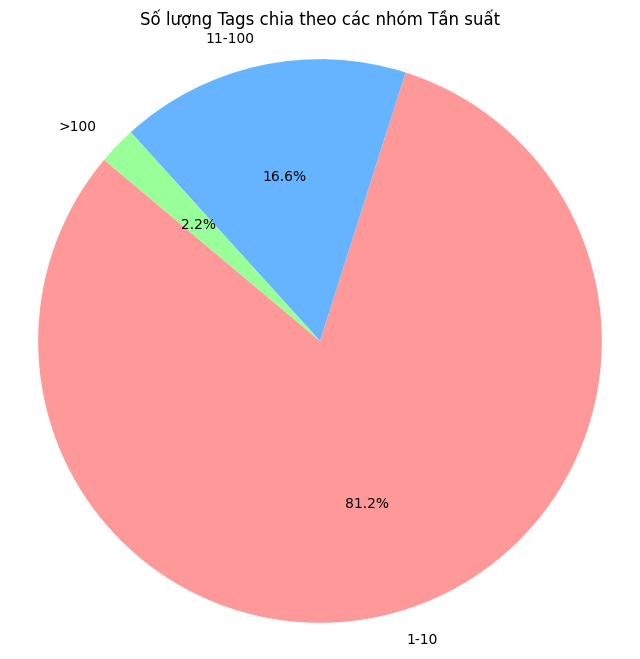

In [50]:
plt.figure(figsize=(8, 8))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']

plt.pie(frequency_counts, labels=frequency_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Số lượng Tags chia theo các nhóm Tần suất')
plt.axis('equal')
plt.show()

Tổng Frequency trong mỗi nhóm:
Frequency_Group
1-10      340688
11-100    805733
>100      769799
Name: Frequency, dtype: int64


/tmp/ipykernel_24/2511800900.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frequency_sum = tags_df.groupby('Frequency_Group')['Frequency'].sum()


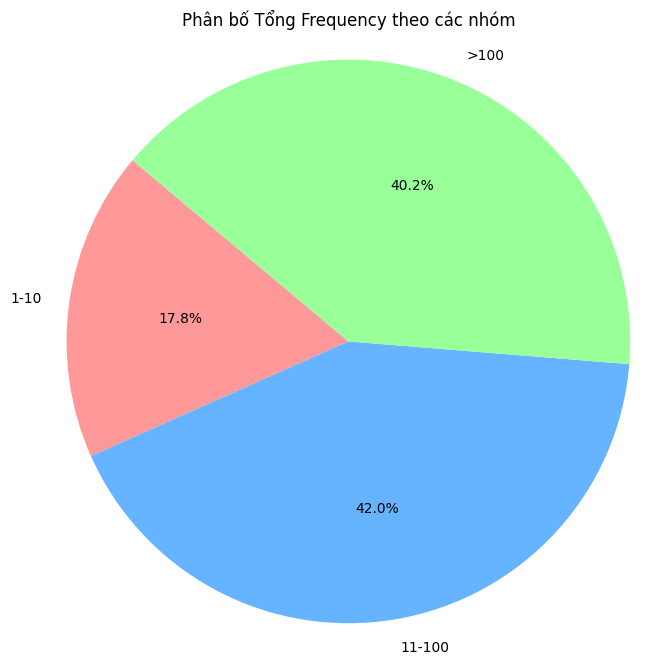

In [51]:
# Tính tổng Frequency trong mỗi nhóm
frequency_sum = tags_df.groupby('Frequency_Group')['Frequency'].sum()

print("Tổng Frequency trong mỗi nhóm:")
print(frequency_sum)

plt.figure(figsize=(8, 8))
plt.pie(frequency_sum, labels=frequency_sum.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Phân bố Tổng Frequency theo các nhóm')
plt.axis('equal')
plt.show()

* **Trong tập tags đã loại bỏ trùng lặp thì những tag xuất hiện < 10 lần chiếm hơn 80%.** **Tuy nhiên, tổng số lần xuất hiện của những tag này chỉ chiếm khoảng 18%**
* **Ngược lại, với các tags đã loại bỏ trùng lặp thì những tag xuất hiện >100 chỉ chiếm 2%.** **Nhưng có tổng số lần xuất hiện 40%**
* **=> Tập dữ liệu đang bị mất cân bằng giữa các tag:**

> Đặc Điểm Phân Bố:

* Phân Bố Bất Đồng Đều (Skewed Distribution):
* Dữ liệu thể hiện một phân bố bất đối xứng, trong đó một số lượng lớn tags xuất hiện ít lần, trong khi một số ít tags xuất hiện rất nhiều lần.
* Điều này tương tự với phân bố theo quy luật Pareto (80/20), nhưng ở đây tỷ lệ không hoàn toàn theo quy luật này. Thay vào đó, chúng ta thấy rằng * 80% số lượng tags chỉ đóng góp 18% tổng số lần xuất hiện, và 2% số lượng tags đóng góp 40% tổng số lần xuất hiện.

> Hiệu Ứng Long Tail:
* Phần lớn các tags nằm ở đuôi dài của phân bố, xuất hiện ít lần nhưng tổng hợp lại tạo thành một phần nhỏ của tổng số lần xuất hiện.
* Điều này cho thấy rằng hệ thống có nhiều tags ít phổ biến nhưng tổng cộng chúng lại không chiếm ưu thế trong việc thể hiện nội dung hoặc chủ đề * chính.

> Tầm Quan Trọng của Các Tags Phổ Biến:

* Tags Phổ Biến Làm Nên Phần Lớn Tổng Xuất Hiện.
* Mặc dù chỉ chiếm 2% tổng số tags, những tags này lại góp phần 40% tổng số lần xuất hiện, chứng tỏ chúng có tầm quan trọng lớn trong việc định * * hình nội dung chính hoặc các chủ đề nổi bật.
* Điều này có thể phản ánh các chủ đề chính hoặc từ khóa quan trọng trong dữ liệu của bạn.

In [52]:
# Phân loại loại từ cho các tag
def classify_by_pos(tags_df):
    pos_dict = {}

    for index, row in tags_df.iterrows():
        for word, pos in row['POS_Types']:
            if pos not in pos_dict:
                pos_dict[pos] = []  # Khởi tạo một danh sách trống nếu chưa có loại từ này
            pos_dict[pos].append({'Tag': row['Tag'], 'Frequency': row['Frequency'], 'POS': pos})
    

    pos_dataframes = {pos: pd.DataFrame(data) for pos, data in pos_dict.items()}
    
    return pos_dataframes

pos_dataframes = classify_by_pos(tags_df)

for pos, df in pos_dataframes.items():
    if pos in ['N', 'Np', 'V', 'A']:
        print(f"DataFrame cho loại từ {pos}:")
        print(df, "\n")

DataFrame cho loại từ Np:
                          Tag  Frequency POS
0                      Israel       2682  Np
1               Liên bang Nga       2358  Np
2               Liên bang Nga       2358  Np
3                      TP.HCM       2246  Np
4                     Ukraine       1449  Np
...                       ...        ...  ..
159519  Báo Nhân dân nhân dịp          1  Np
159520               Zalo SOS          1  Np
159521               Zalo SOS          1  Np
159522  Tổng đài 1022 Đà Nẵng          1  Np
159523         Trần Hồng Ninh          1  Np

[159524 rows x 3 columns] 

DataFrame cho loại từ N:
                         Tag  Frequency POS
0                        bão       2096   N
1                   giá vàng       1476   N
2                   giá vàng       1476   N
3                  xét tuyển       1348   N
4                 điểm chuẩn       1283   N
...                      ...        ...  ..
72009          Kirin 9010 5G          1   N
72010             Smart card

In [53]:
main_pos = ['N', 'Np', 'V', 'A']

frequency_distribution = {pos: 0 for pos in main_pos}
frequency_distribution['Other'] = 0

# Tính tổng Frequency cho từng loại từ
for pos, df in pos_dataframes.items():
    total_freq = df['Frequency'].sum()
    if pos in main_pos:
        frequency_distribution[pos] += total_freq
    else:
        frequency_distribution['Other'] += total_freq

print("Tổng Frequency cho các loại từ:")
for pos, freq in frequency_distribution.items():
    print(f"{pos}: {freq}")

Tổng Frequency cho các loại từ:
N: 829518
Np: 985533
V: 279272
A: 83835
Other: 934859


In [54]:
labels = list(frequency_distribution.keys())
sizes = list(frequency_distribution.values())

total = sum(sizes)
sizes_percent = [size / total * 100 for size in sizes]

for label, size, percent in zip(labels, sizes, sizes_percent):
    print(f"{label}: {size} ({percent:.2f}%)")

N: 829518 (26.65%)
Np: 985533 (31.66%)
V: 279272 (8.97%)
A: 83835 (2.69%)
Other: 934859 (30.03%)


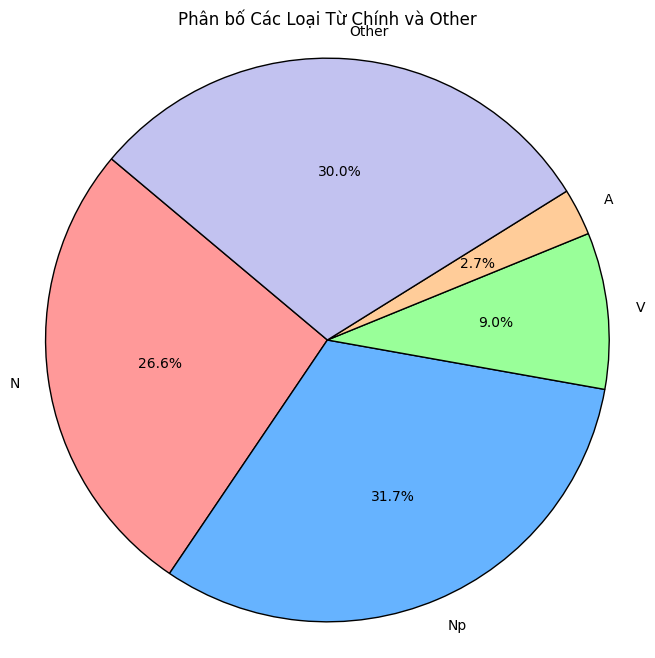

In [55]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Phân bố Các Loại Từ Chính và Other')
plt.axis('equal')
plt.show()

In [56]:
# Định nghĩa các loại từ chính
main_pos = ['N', 'Np', 'V', 'A']

# Khởi tạo từ điển để lưu tổng Frequency cho các loại từ chính và 'Other'
frequency_distribution = {pos: 0 for pos in main_pos}
frequency_distribution['Other'] = 0

# Tính tổng Frequency cho từng loại từ
for pos, df in pos_dataframes.items():
    total_freq = df['Frequency'].shape[0]
    if pos in main_pos:
        frequency_distribution[pos] += total_freq
    else:
        frequency_distribution['Other'] += total_freq

print("Tổng Frequency cho các loại từ:")
for pos, freq in frequency_distribution.items():
    print(f"{pos}: {freq}")

Tổng Frequency cho các loại từ:
N: 72014
Np: 159524
V: 15942
A: 4961
Other: 51117


In [57]:
labels = list(frequency_distribution.keys())
sizes = list(frequency_distribution.values())

total = sum(sizes)
sizes_percent = [size / total * 100 for size in sizes]

for label, size, percent in zip(labels, sizes, sizes_percent):
    print(f"{label}: {size} ({percent:.2f}%)")

N: 72014 (23.72%)
Np: 159524 (52.55%)
V: 15942 (5.25%)
A: 4961 (1.63%)
Other: 51117 (16.84%)


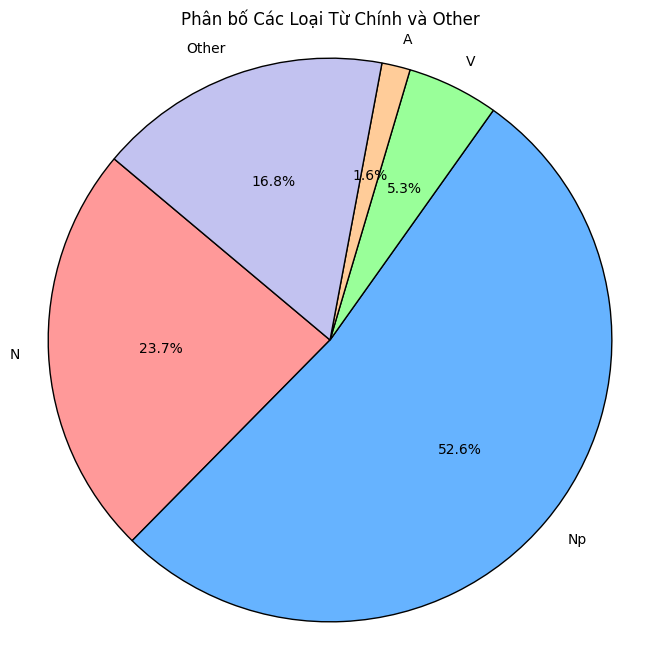

In [58]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']

# Vẽ Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Phân bố Các Loại Từ Chính và Other')
plt.axis('equal')  
plt.show()

* Khi phân tích loại từ cho các tags, nhận thấy loại từ là danh từ (N) và danh từ chỉ tên riêng (Np) có tổng số lần xuất hiện lần lượt là (26.64%) và (31.63%), chiếm đa số so với Tính từ (A) (8.98%), Động từ (V) (2.70%) và các từ khác (Other) (30.06%) **
* Không những vậy, trong tập tags không trùng nhau, loại từ là danh từ (N) và danh từ chỉ tên riêng (Np) cũng chiếm tỉ lệ lớn đó là (23.7%) và (52,6%)

> Sự Phổ Biến của Danh Từ và Danh Từ Chỉ Tên Riêng:
* Danh từ (N) và Danh từ chỉ tên riêng (Np) chiếm gần 58.27% tổng số lần xuất hiện (26.64% + 31.63%) và 76.3% trong tập tags không trùng lặp * (23.7% + 52.6%). Điều này cho thấy rằng hầu hết các tags đều liên quan đến các danh từ, đặc biệt là danh từ chỉ tên riêng.

> Vai Trò của Các Loại Từ Khác:
* Tính từ (A) và Động từ (V) chiếm tỷ lệ tương đối nhỏ trong cả tổng số lần xuất hiện và trong tập tags không trùng lặp.
* Các loại từ khác (Other) chiếm khoảng 30.06% tổng số lần xuất hiện và khoảng 23.7% trong tập tags không trùng lặp. Điều này cho thấy có sự đa dạng trong các loại từ được sử dụng nhưng không phải là phần chính.

> Phân Bố Đa Dạng Trong Tập Tags:
* Tags không trùng lặp có tỷ lệ cao của danh từ chỉ tên riêng (Np) (52.6%), cho thấy nhiều tags độc đáo và có tính đặc thù cao.
* Tags trùng lặp (nếu xem xét tổng số lần xuất hiện so với số lượng tags) có xu hướng tập trung vào các danh từ và danh từ chỉ tên riêng, điều này có thể phản ánh sự phổ biến của các chủ đề hoặc thực thể nhất định trong dữ liệu của bạn.

### 3.1.2 Khám phá tỉ lệ tag xuất hiện có trong content

In [59]:
def check_tag_presence_ratio(content, tags):
    tag_list = tags.split(',')  
    found_count = sum(1 for tag in tag_list if tag in content)  
    return found_count / len(tag_list)  
    
# Áp dụng hàm để tính tỷ lệ xuất hiện cho từng hàng
data['Tag_Presence_Ratio'] = data.apply(lambda row: check_tag_presence_ratio(row['content'], row['tags']), axis=1)

print(data[['tags', 'Tag_Presence_Ratio']])

                                                    tags  Tag_Presence_Ratio
0      La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,...                0.75
1      Estevao Willian,Neymar,giải VĐQG Brazil,Serie ...                0.85
3      đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục...                0.70
4      toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề...                0.80
5      Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa...                0.95
...                                                  ...                 ...
99845  Kỳ họp,Quốc hội,tư duy,Trần Thanh Mẫn,nguồn lự...                1.00
99846  cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư...                0.70
99847  Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc...                0.95
99848  Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ...                0.85
99849  đấu thầu,vật tư,hóa chất,thiết bị y tế,thông t...                0.85

[95811 rows x 2 columns]


In [60]:
from scipy import stats
# Thực hiện K-S Test
ks_statistic, ks_p_value = stats.kstest(data['Tag_Presence_Ratio'], 'norm', args=(data['Tag_Presence_Ratio'].mean(), data['Tag_Presence_Ratio'].std()))

print(f"K-S Statistic: {ks_statistic}")
print(f"P-Value: {ks_p_value}")

K-S Statistic: 0.1479791442706488
P-Value: 0.0


> => Không tuân theo phân bố chuẩn

In [61]:
# Tính toán thống kê cơ bản
std_dev = data['Tag_Presence_Ratio'].std()
variance = data['Tag_Presence_Ratio'].var()
mean_tags_length = data['Tag_Presence_Ratio'].mean()
sample_size = data['Tag_Presence_Ratio'].count()

print("\nĐộ lệch chuẩn của Tag_Presence_Ratio: ", std_dev)
print("Phương sai của Tag_Presence_Ratio: ", variance)
print("Trung bình Tag_Presence_Ratio: ", mean_tags_length)
print("Kích thước mẫu: ", sample_size)


Độ lệch chuẩn của Tag_Presence_Ratio:  0.12284334297000693
Phương sai của Tag_Presence_Ratio:  0.01509048691204675
Trung bình Tag_Presence_Ratio:  0.8183851541054785
Kích thước mẫu:  95811


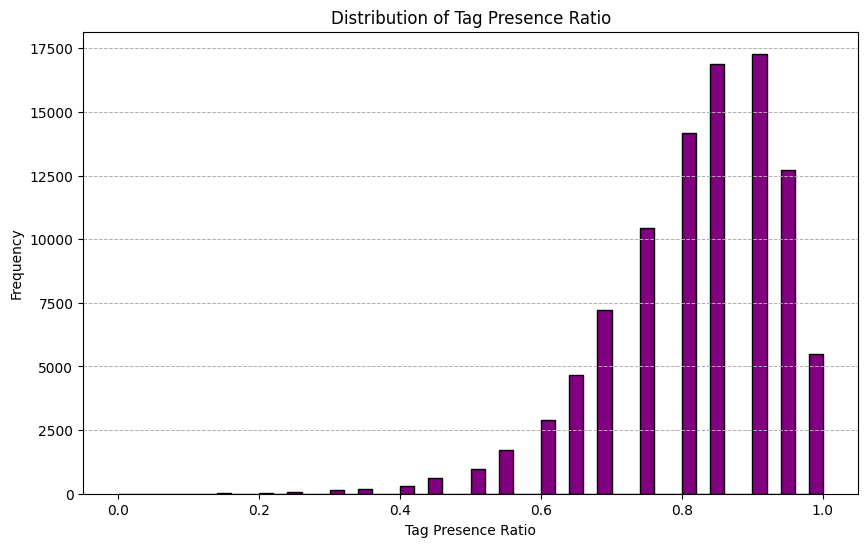

In [62]:
# Trực quan hóa phân bố của cột Tag_Presence_Ratio
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ phân phối cho Tag_Presence_Ratio
plt.hist(data['Tag_Presence_Ratio'], bins=50, color='purple', edgecolor='black')
plt.xlabel('Tag Presence Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Tag Presence Ratio')
plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()

> * Đa số nhãn sẽ được lấy từ trong văn bản Content (khoảng 75% - 100%) 
> *  Ngoài ra, từ phần trên, nhóm rút ra được số lượng tag suất hiện (gần 20 tag mỗi contetn): sẽ từ 16-20 tag/tổng 20 tag 

In [63]:
# Hàm kiểm tra thứ tự xuất hiện của các tag trong content
def check_tag_order(content, tags):
    tag_list = tags.split(',')
    last_index = -1
    for tag in tag_list:
        current_index = content.find(tag)
        if current_index == -1:
            return f"Tag '{tag}' không có trong content"
        if current_index < last_index:
            return f"Thứ tự tag '{tag}' không đúng"
        last_index = current_index
    return "Thứ tự tag đúng"

data['Tag_Order_Check'] = data.apply(lambda row: check_tag_order(row['content'], row['tags']), axis=1)

print(data[['tags', 'Tag_Order_Check']])

                                                    tags  \
0      La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,...   
1      Estevao Willian,Neymar,giải VĐQG Brazil,Serie ...   
3      đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục...   
4      toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề...   
5      Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa...   
...                                                  ...   
99845  Kỳ họp,Quốc hội,tư duy,Trần Thanh Mẫn,nguồn lự...   
99846  cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư...   
99847  Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc...   
99848  Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ...   
99849  đấu thầu,vật tư,hóa chất,thiết bị y tế,thông t...   

                                 Tag_Order_Check  
0                Thứ tự tag 'Sevilla' không đúng  
1                 Thứ tự tag 'Neymar' không đúng  
3             Tag 'ASIAD' không có trong content  
4                    Thứ tự tag 'lặn' không đúng  
5         Thứ tự tag 'Gi

> Kết luận thứ tự các tag là ngẫu nhiên, không tuân theo thứ tự các từ trong content

### 3.1.3 N-gram cho các tag

In [ ]:
def get_tags_by_word_length(tags_list, word_length):
    return [tag for tag in tags_list if len(tag.split()) == word_length]

tags_6_words = data['tags_list'].apply(lambda tags: get_tags_by_word_length(tags, 6)).sum()
tags_5_words = data['tags_list'].apply(lambda tags: get_tags_by_word_length(tags, 5)).sum()
tags_4_words = data['tags_list'].apply(lambda tags: get_tags_by_word_length(tags, 4)).sum()
tags_3_words = data['tags_list'].apply(lambda tags: get_tags_by_word_length(tags, 3)).sum()
tags_2_words = data['tags_list'].apply(lambda tags: get_tags_by_word_length(tags, 2)).sum()
tags_1_words = data['tags_list'].apply(lambda tags: get_tags_by_word_length(tags, 1)).sum()

In [ ]:
print(tags_6_words[:10])

In [ ]:
n_gram_counts = {
    '1-word': tags_1_words,
    '2-word': tags_2_words,
    '3-word': tags_3_words,
    '4-word': tags_4_words,
    '5-word': tags_5_words,
    '6-word': tags_6_words
}

n_gram_lengths = {key: len(value) for key, value in n_gram_counts.items()}

max_n_gram = max(n_gram_lengths, key=n_gram_lengths.get)
max_length = n_gram_lengths[max_n_gram]

print("Độ dài mảng cho từng nhóm n-gram:")
for n_gram, length in n_gram_lengths.items():
    print(f"{n_gram}: {length} phần tử")

print(f"\nNhóm n-gram có độ dài mảng lớn nhất là {max_n_gram} với số lượng: {max_length} phần tử")

In [ ]:
labels = list(n_gram_lengths.keys())       # Các nhóm n-gram
sizes = list(n_gram_lengths.values())      # Số lượng phần tử trong mỗi nhóm

max_n_gram = max(n_gram_lengths, key=n_gram_lengths.get)

explode = [0.1 if label == max_n_gram else 0 for label in labels]

plt.figure(figsize=(8, 8)) 

plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',       
    startangle=140,          
    explode=explode,          
    colors=plt.cm.Paired.colors  
)

plt.title('Phân bố Số Lượng Các Nhóm N-gram')  
plt.axis('equal') 
plt.show() 

> Các tag theo n-gram thì 1, 2, 3 chiếm gần 90% => Khía cạnh để sử dụng trích xuất các từ bằng KeyBert

## 3.2. Content

In [65]:
data.head()

,content,tags,tags_list,tags_length,Content_Word_Count,Tags_Word_Count,has_stopword,found_stopwords,clean_content,Tag_Presence_Ratio,Tag_Order_Check
0,"Bước vào trận đấu, Barcelona nhanh chóng tràn ...","La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,...","[La Liga, Sevilla, Olimpic Lluis Companys, đè ...",20,217,40,False,[],"Bước trận đấu , Barcelona nhanh chóng tràn tấn...",0.75,Thứ tự tag 'Sevilla' không đúng
1,Willian đi vào lịch sử bóng đá xứ samba. Với 1...,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ...","[Estevao Willian, Neymar, giải VĐQG Brazil, Se...",20,314,41,False,[],Willian đi lịch sử bóng đá xứ samba . Với 1 bà...,0.85,Thứ tự tag 'Neymar' không đúng
3,Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục...","[đăng cai, Đại hội Thể thao châu Á, ASIAD, thể...",20,903,72,False,[],Mục tiêu Phó Thủ tướng Chính phủ Lê Thành Long...,0.70,Tag 'ASIAD' không có trong content
4,"Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề...","[toàn đoàn, lặn, Vũ Đặng Nhật Nam, Nguyễn Lê T...",20,364,50,False,[],"Ngày 20-10 , Giải bơi lặn vô địch quốc gia năm...",0.80,Thứ tự tag 'lặn' không đúng
5,"Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...","Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa...","[Hồng Hà, Giàng Thị Dung, đua xe đạp, Lào Cai,...",20,997,56,False,[],"Đồng chí Giàng Thị Dung , Phó Chủ tịch UBND tỉ...",0.95,Thứ tự tag 'Giàng Thị Dung' không đúng


In [66]:
data['Content_Word_Count'] = data['content'].apply(lambda x: len(x.split()))
print(data[['content', 'Content_Word_Count']])

                                                 content  Content_Word_Count
0      Bước vào trận đấu, Barcelona nhanh chóng tràn ...                 217
1      Willian đi vào lịch sử bóng đá xứ samba. Với 1...                 314
3      Mục tiêu lớn Phó Thủ tướng Chính phủ Lê Thành ...                 903
4      Ngày 20-10, Giải bơi và lặn vô địch quốc gia n...                 364
5      Đồng chí Giàng Thị Dung, Phó Chủ tịch UBND tỉn...                 997
...                                                  ...                 ...
99845  Tạo động lực phát triển nhanh và bền vững của ...                1136
99846  Theo số liệu của Tổng cục Hải quan, trong 9 th...                 647
99847  Mong có chiến lược ứng phó hiệu quả với thiên ...                1360
99848  Nhà chức trách xác định, Hoàng Văn Thảo có hàn...                 353
99849  Trong 6 tháng đầu năm 2024, Sở Y tế thành phố ...                 689

[95811 rows x 2 columns]


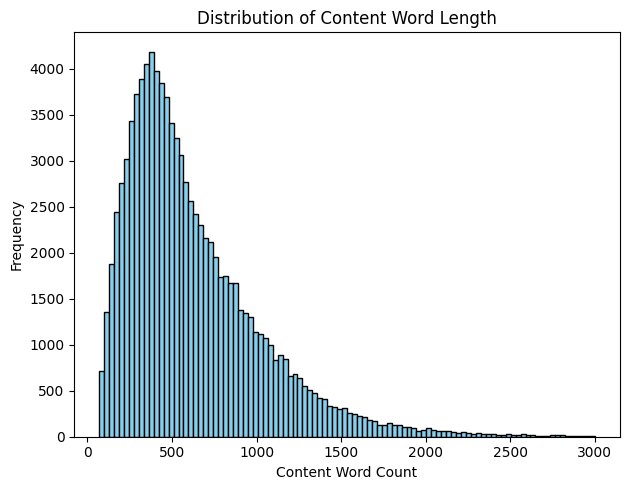

In [67]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data['Content_Word_Count'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Content Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Content Word Length')

plt.tight_layout()
plt.show()

In [68]:
data1 = data[(data['Content_Word_Count'] <= 800)]
data1.shape[0]

70680

> * Nếu sử dụng Mô hình có max_token_length=1024 sẽ kiểm soát được 85% độ dài theo token của Content
> * Nếu sử dụng Mô hình có max_token_length=800 sẽ kiểm soát được 73% độ dài theo token của Content
> * Còn nếu sử dụng Mô hình có max_token_length=512 sẽ chỉ kiểm soát được 49% độ dài theo token của Content 

## 3.3. WordCloud

### 3.3.1 WordCloud về chủ đề thể thao

In [69]:
add_stopwords = [
    "a lô", "a ha", "ai", "ai ai", "ai nấy", "ai đó", "alô", "amen",
    "anh", "anh ấy", "ba", "ba ba", "ba bản", "ba cùng", "ba họ", "ba ngày",
    "ba ngôi", "ba tăng", "bao giờ", "bao lâu", "bao nhiêu", "bao nả",
    "bay biến", "biết", "biết bao", "biết bao nhiêu", "biết chắc",
    "biết chừng nào", "biết mình", "biết mấy", "biết thế", "biết trước",
    "biết việc", "biết đâu", "biết đâu chừng", "biết đâu đấy",
    "biết được", "buổi", "buổi làm", "buổi mới", "buổi ngày", "buổi sớm",
    "bà", "bà ấy", "bài", "bài bác", "bài bỏ", "bài cái", "bác", "bán",
    "bán cấp", "bán dạ", "bán thế", "bây bẩy", "bây chừ", "bây giờ",
    "bây nhiêu", "bèn", "béng", "bên", "bên bị", "bên có", "bên cạnh",
    "bông", "bước", "bước khỏi", "bước tới", "bước đi", "bạn", "bản",
    "bản bộ", "bản riêng", "bản thân", "bản ý", "bất chợt", "bất cứ",
    "bất giác", "bất kì", "bất kể", "bất kỳ", "bất luận", "bất ngờ",
    "bất nhược", "bất quá", "bất quá chỉ", "bất thình lình", "bất tử",
    "bất đồ", "bấy", "bấy chầy", "bấy chừ", "bấy giờ", "bấy lâu",
    "bấy lâu nay", "bấy nay", "bấy nhiêu", "bập bà bập bõm", "bập bõm",
    "bắt đầu", "bắt đầu từ", "bằng", "bằng cứ", "bằng không", "bằng người",
    "bằng nhau", "bằng như", "bằng nào", "bằng nấy", "bằng vào",
    "bằng được", "bằng ấy", "bển", "bệt", "bị", "bị chú", "bị vì",
    "bỏ", "bỏ bà", "bỏ cha", "bỏ cuộc", "bỏ không", "bỏ lại",
    "bỏ mình", "bỏ mất", "bỏ mẹ", "bỏ nhỏ", "bỏ quá", "bỏ ra",
    "bỏ riêng", "bỏ việc", "bỏ xa", "bỗng", "bỗng chốc", "bỗng dưng",
    "bỗng không", "bỗng nhiên", "bỗng nhưng", "bỗng thấy", "bỗng đâu",
    "bộ", "bộ thuộc", "bộ điều", "bội phần", "bớ", "bởi", "bởi ai",
    "bởi chưng", "bởi nhưng", "bởi sao", "bởi thế", "bởi thế cho nên",
    "bởi tại", "bởi vì", "bởi vậy", "bởi đâu", "bức", "cao", "cao lâu",
    "cao ráo", "cao răng", "cao sang", "cao số", "cao thấp", "cao thế",
    "cao xa", "cha", "cha chả", "chao ôi", "chia sẻ", "chiếc", "cho",
    "cho biết", "cho chắc", "cho hay", "cho nhau", "cho nên", "cho rằng",
    "cho rồi", "cho thấy", "cho tin", "cho tới", "cho tới khi", "cho về",
    "cho ăn", "cho đang", "cho được", "cho đến", "cho đến khi", "cho đến nỗi",
    "choa", "chu cha", "chui cha", "chung", "chung cho", "chung chung",
    "chung cuộc", "chung cục", "chung nhau", "chung qui", "chung quy",
    "chung quy lại", "chung ái", "chuyển", "chuyển tự", "chuyển đạt",
    "chuyện", "chuẩn bị", "chành chạnh", "chí chết", "chính", "chính bản",
    "chính giữa", "chính là", "chính thị", "chính điểm", "chùn chùn",
    "chùn chũn", "chú", "chú dẫn", "chú khách", "chú mày", "chú mình",
    "chúng", "chúng mình", "chúng ta", "chúng tôi", "chúng ông",
    "chăn chắn", "chăng", "chăng chắc", "chăng nữa", "chơi", "chơi họ",
    "chưa", "chưa bao giờ", "chưa chắc", "chưa có", "chưa cần",
    "chưa dùng", "chưa dễ", "chưa kể", "chưa tính", "chưa từng",
    "chầm chập", "chậc", "chắc", "chắc chắn", "chắc dạ", "chắc hẳn",
    "chắc lòng", "chắc người", "chắc vào", "chắc ăn", "chẳng lẽ",
    "chẳng những", "chẳng nữa", "chẳng phải", "chết nỗi", "chết thật",
    "chết tiệt", "chỉ", "chỉ chính", "chỉ có", "chỉ là", "chỉ tên",
    "chỉn", "chị", "chị bộ", "chị ấy", "chịu", "chịu chưa", "chịu lời",
    "chịu tốt", "chịu ăn", "chọn", "chọn bên", "chọn ra", "chốc chốc",
    "chớ", "chớ chi", "chớ gì", "chớ không", "chớ kể", "chớ như",
    "chợt", "chợt nghe", "chợt nhìn", "chủn", "chứ", "chứ ai",
    "chứ còn", "chứ gì", "chứ không", "chứ không phải", "chứ lại",
    "chứ lị", "chứ như", "chứ sao", "coi bộ", "coi mòi", "con",
    "con con", "con dạ", "con nhà", "con tính", "cu cậu", "cuối",
    "cuối cùng", "cuối điểm", "cuốn", "cuộc", "càng", "càng càng",
    "càng hay", "cá nhân", "các", "các cậu", "cách", "cách bức",
    "cách không", "cách nhau", "cách đều", "cái", "cái gì", "cái họ",
    "cái đã", "cái đó", "cái ấy", "câu hỏi", "cây", "cây nước",
    "còn", "còn như", "còn nữa", "còn thời gian", "còn về",
    "có", "có ai", "có chuyện", "có chăng", "có chăng là",
    "có chứ", "có cơ", "có dễ", "có họ", "có khi", "có ngày",
    "có người", "có nhiều", "có nhà", "có phải", "có số", "có tháng",
    "có thế", "có thể", "có vẻ", "có ý", "có ăn", "có điều",
    "có điều kiện", "có đáng", "có đâu", "có được", "cóc khô",
    "cô", "cô mình", "cô quả", "cô tăng", "cô ấy", "công nhiên",
    "cùng", "cùng chung", "cùng cực", "cùng nhau", "cùng tuổi",
    "cùng tột", "cùng với", "cùng ăn", "căn", "căn cái", "căn cắt",
    "căn tính", "cũng", "cũng như", "cũng nên", "cũng thế",
    "cũng vậy", "cũng vậy thôi", "cũng được", "cơ", "cơ chỉ",
    "cơ chừng", "cơ cùng", "cơ dẫn", "cơ hồ", "cơ hội", "cơ mà",
    "cơn", "cả", "cả nghe", "cả nghĩ", "cả ngày", "cả người",
    "cả nhà", "cả năm", "cả thảy", "cả thể", "cả tin", "cả ăn",
    "cả đến", "cảm thấy", "cảm ơn", "cấp", "cấp số", "cấp trực tiếp",
    "cần", "cần cấp", "cần gì", "cần số", "cật lực", "cật sức",
    "cậu", "cổ lai", "cụ thể", "cụ thể là", "cụ thể như", "của",
    "của ngọt", "của tin", "cứ", "cứ như", "cứ việc", "cứ điểm",
    "cực lực", "do", "do vì", "do vậy", "do đó", "duy", "duy chỉ",
    "duy có", "dài", "dài lời", "dài ra", "dành", "dành dành",
    "dào", "dì", "dù", "dù cho", "dù dì", "dù gì", "dù rằng",
    "dù sao", "dùng", "dùng cho", "dùng hết", "dùng làm", "dùng đến",
    "dưới", "dưới nước", "dạ", "dạ bán", "dạ con", "dạ dài",
    "dạ dạ", "dạ khách", "dần dà", "dần dần", "dầu sao",
    "dẫn", "dẫu", "dẫu mà", "dẫu rằng", "dẫu sao", "dễ",
    "dễ dùng", "dễ gì", "dễ khiến", "dễ nghe", "dễ ngươi",
    "dễ như chơi", "dễ sợ", "dễ sử dụng", "dễ thường",
    "dễ thấy", "dễ ăn", "dễ đâu", "dở chừng", "dữ", "dữ cách",
    "em", "em em", "giá trị", "giá trị thực tế", "giảm",
    "giảm chính", "giảm thấp", "giảm thế", "giống", "giống người",
    "giống nhau", "giống như", "giờ", "giờ lâu", "giờ này",
    "giờ đi", "giờ đây", "giờ đến", "giữ", "giữ lấy", "giữ ý",
    "giữa", "giữa lúc", "gây", "gây cho", "gây giống", "gây ra",
    "gây thêm", "gì", "gì gì", "gì đó", "gần", "gần bên", "gần hết",
    "gần ngày", "gần như", "gần xa", "gần đây", "gần đến", "gặp",
    "gặp khó khăn", "gặp phải", "gồm", "hay", "hay biết", "hay hay",
    "hay không", "hay là", "hay làm", "hay nhỉ", "hay nói",
    "hay sao", "hay tin", "hay đâu", "hiểu", "hiện nay", "hiện tại",
    "hoàn toàn", "hoặc", "hoặc là", "hãy", "hãy còn", "hơn",
    "hơn cả", "hơn hết", "hơn là", "hơn nữa", "hơn trước",
    "hầu hết", "hết", "hết chuyện", "hết cả", "hết của",
    "hết nói", "hết ráo", "hết rồi", "hết ý", "họ", "họ gần",
    "họ xa", "hỏi", "hỏi lại", "hỏi xem", "hỏi xin", "hỗ trợ",
    "khi", "khi khác", "khi không", "khi nào", "khi nên",
    "khi trước", "khiến", "khoảng", "khoảng cách", "khoảng không",
    "khá", "khá tốt", "khác", "khác gì", "khác khác", "khác nhau",
    "khác nào", "khác thường", "khác xa", "khách", "khó",
    "khó biết", "khó chơi", "khó khăn", "khó làm", "khó mở",
    "khó nghe", "khó nghĩ", "khó nói", "khó thấy", "khó tránh",
    "không", "không ai", "không bao giờ", "không bao lâu",
    "không biết", "không bán", "không chỉ", "không còn", "không có",
    "không có gì", "không cùng", "không cần", "không cứ", "không dùng",
    "không gì", "không hay", "không khỏi", "không kể",
    "không ngoài", "không nhận", "không những", "không phải",
    "không phải không", "không thể", "không tính",
    "không điều kiện", "không được", "không đầy", "không để",
    "khẳng định", "khỏi", "khỏi nói", "kể", "kể cả", "kể như",
    "kể tới", "kể từ", "liên quan", "loại", "loại từ", "luôn",
    "luôn cả", "luôn luôn", "luôn tay", "là", "là cùng", "là là",
    "là nhiều", "là phải", "là thế nào", "là vì", "là ít",
    "làm", "làm bằng", "làm cho", "làm dần dần", "làm gì",
    "làm lòng", "làm lại", "làm lấy", "làm mất", "làm ngay",
    "làm như", "làm nên", "làm ra", "làm riêng", "làm sao",
    "làm theo", "làm thế nào", "làm tin", "làm tôi", "làm tăng",
    "làm tại", "làm tắp lự", "làm vì", "làm đúng", "làm được",
    "lâu", "lâu các", "lâu lâu", "lâu nay", "lâu ngày", "lên",
    "lên cao", "lên cơn", "lên mạnh", "lên ngôi", "lên nước",
    "lên số", "lên xuống", "lên đến", "lòng", "lòng không",
    "lúc", "lúc khác", "lúc lâu", "lúc nào", "lúc này",
    "lúc sáng", "lúc trước", "lúc đi", "lúc đó", "lúc đến",
    "lúc ấy", "lý do", "lượng", "lượng cả", "lượng số", "lượng từ",
    "lại", "lại bộ", "lại cái", "lại còn", "lại giống", "lại làm",
    "lại người", "lại nói", "lại nữa", "lại quả", "lại thôi",
    "lại ăn", "lại đây", "lấy", "lấy có", "lấy cả", "lấy giống",
    "lấy làm", "lấy lý do", "lấy lại", "lấy ra", "lấy ráo",
    "lấy sau", "lấy số", "lấy thêm", "lấy thế", "lấy vào",
    "lấy xuống", "lấy được", "lấy để", "lần", "lần khác",
    "lần lần", "lần nào", "lần này", "lần sang", "lần sau",
    "lần theo", "lần trước", "lần tìm", "lớn", "lớn lên", "lớn nhỏ",
    "lời", "lời chú", "lời nói", "mang", "mang lại", "mang mang",
    "mang nặng", "mang về", "muốn", "mà", "mà cả", "mà không",
    "mà lại", "mà thôi", "mà vẫn", "mình", "mạnh", "mất",
    "mất còn", "mọi", "mọi giờ", "mọi khi", "mọi lúc", "mọi người",
    "mọi nơi", "mọi sự", "mọi thứ", "mọi việc", "mối", "mỗi",
    "mỗi lúc", "mỗi lần", "mỗi một", "mỗi ngày", "mỗi người",
    "một", "một cách", "một cơn", "một khi", "một lúc",
    "một số", "một vài", "một ít", "mới", "mới hay", "mới rồi",
    "mới đây", "mở", "mở mang", "mở nước", "mở ra", "mợ", "mức",
    "nay", "ngay", "ngay bây giờ", "ngay cả", "ngay khi",
    "ngay khi đến", "ngay lúc", "ngay lúc này", "ngay lập tức",
    "ngay thật", "ngay tức khắc", "ngay tức thì", "ngay từ",
    "nghe", "nghe chừng", "nghe hiểu", "nghe không", "nghe lại",
    "nghe nhìn", "nghe như", "nghe nói", "nghe ra", "nghe rõ",
    "nghe thấy", "nghe tin", "nghe trực tiếp", "nghe đâu",
    "nghe đâu như", "nghe được", "nghen", "nghiễm nhiên", "nghĩ",
    "nghĩ lại", "nghĩ ra", "nghĩ tới", "nghĩ xa", "nghĩ đến",
    "nghìm", "ngoài", "ngoài này", "ngoài ra", "ngoài xa", "ngoải",
    "nguồn", "ngày", "ngày càng", "ngày cấp", "ngày giờ",
    "ngày ngày", "ngày nào", "ngày này", "ngày nọ", "ngày qua",
    "ngày rày", "ngày tháng", "ngày xưa", "ngày xửa", "ngày đến",
    "ngày ấy", "ngôi", "ngôi nhà", "ngôi thứ", "ngõ hầu",
    "ngăn ngắt", "ngươi", "người", "người hỏi", "người khác",
    "người khách", "người mình", "người nghe", "người người",
    "người nhận", "ngọn", "ngọn nguồn", "ngọt", "ngồi",
    "ngồi bệt", "ngồi không", "ngồi sau", "ngồi trệt", "ngộ nhỡ",
    "nhanh", "nhanh lên", "nhanh tay", "nhau", "nhiên hậu",
    "nhiều", "nhiều ít", "nhiệt liệt", "nhung nhăng", "nhà",
    "nhà chung", "nhà khó", "nhà làm", "nhà ngoài", "nhà ngươi",
    "nhà tôi", "nhà việc", "nhân dịp", "nhân tiện", "nhé",
    "nhìn", "nhìn chung", "nhìn lại", "nhìn nhận", "nhìn theo",
    "nhìn thấy", "nhìn xuống", "nhóm", "nhón nhén", "như",
    "như ai", "như chơi", "như không", "như là", "như nhau",
    "như quả", "như sau", "như thường", "như thế", "như thế nào",
    "như thể", "như trên", "như trước", "như tuồng", "như vậy",
    "như ý", "nhưng", "nhưng mà", "nhược bằng", "nhất",
    "nhất loạt", "nhất luật", "nhất là", "nhất mực", "nhất nhất",
    "nhất quyết", "nhất sinh", "nhất thiết", "nhất thì",
    "nhất tâm", "nhất tề", "nhất đán", "nhất định", "nhận",
    "nhận biết", "nhận họ", "nhận làm", "nhận nhau", "nhận ra",
    "nhận thấy", "nhận việc", "nhận được", "nhằm", "nhằm khi",
    "nhằm lúc", "nhằm vào", "nhằm để", "nhỉ", "nhỏ",
    "nhỏ người", "nhớ", "nhớ bập bõm", "nhớ lại", "nhớ lấy",
    "nhớ ra", "nhờ", "nhờ chuyển", "nhờ có", "nhờ nhờ",
    "nhờ đó", "nhỡ ra", "những", "những ai", "những khi",
    "những là", "những lúc", "những muốn", "những như", "nào",
    "nào cũng", "nào hay", "nào là", "nào phải", "nào đâu",
    "nào đó", "này", "này nọ", "nên", "nên chi", "nên chăng",
    "nên làm", "nên người", "nên tránh", "nó", "nóc", "nói",
    "nói bông", "nói chung", "nói khó", "nói là", "nói lên",
    "nói lại", "nói nhỏ", "nói phải", "nói qua", "nói ra",
    "nói riêng", "nói rõ", "nói thêm", "nói thật", "nói toẹt",
    "nói trước", "nói tốt", "nói với", "nói xa", "nói ý",
    "nói đến", "nói đủ", "năm", "năm tháng", "nơi", "nơi nơi",
    "nước", "nước bài", "nước cùng", "nước lên", "nước nặng",
    "nước quả", "nước xuống", "nước ăn", "nước đến", "nấy",
    "nặng", "nặng căn", "nặng mình", "nặng về", "nếu", "nếu có",
    "nếu cần", "nếu không", "nếu mà", "nếu như", "nếu thế",
    "nếu vậy", "nếu được", "nền", "nọ", "nớ", "nức nở", "nữa",
    "nữa khi", "nữa là", "nữa rồi", "oai oái", "oái", "pho",
    "phè", "phè phè", "phía", "phía bên", "phía bạn", "phía dưới",
    "phía sau", "phía trong", "phía trên", "phía trước", "phóc",
    "phót", "phù hợp", "phăn phắt", "phương chi", "phải",
    "phải biết", "phải chi", "phải chăng", "phải cách",
    "phải cái", "phải giờ", "phải khi", "phải không",
    "phải lại", "phải lời", "phải người", "phải như", "phải rồi",
    "phải tay", "phần", "phần lớn", "phần nhiều", "phần nào",
    "phần sau", "phần việc", "phắt", "phỉ phui", "phỏng",
    "phỏng như", "phỏng nước", "phỏng theo", "phỏng tính",
    "phốc", "phụt", "phứt", "qua", "qua chuyện", "qua khỏi",
    "qua lại", "qua lần", "qua ngày", "qua tay", "qua thì",
    "qua đi", "quan trọng", "quan trọng vấn đề", "quan tâm",
    "quay", "quay bước", "quay lại", "quay số", "quay đi",
    "quá", "quá bán", "quá bộ", "quá giờ", "quá lời",
    "quá mức", "quá nhiều", "quá tay", "quá thì", "quá tin",
    "quá trình", "quá tuổi", "quá đáng", "quá ư", "quả",
    "quả là", "quả thật", "quả thế", "quả vậy", "quận", "ra",
    "ra bài", "ra bộ", "ra chơi", "ra gì", "ra lại", "ra lời",
    "ra ngôi", "ra người", "ra sao", "ra tay", "ra vào", "ra ý",
    "ra điều", "ra đây", "ren rén", "riu ríu", "riêng",
    "riêng từng", "riệt", "rày", "ráo", "ráo cả", "ráo nước",
    "ráo trọi", "rén", "rén bước", "rích", "rón rén", "rõ",
    "rõ là", "rõ thật", "rút cục", "răng", "răng răng", "rất",
    "rất lâu", "rằng", "rằng là", "rốt cuộc", "rốt cục", "rồi",
    "rồi nữa", "rồi ra", "rồi sao", "rồi sau", "rồi tay",
    "rồi thì", "rồi xem", "rồi đây", "rứa", "sa sả", "sang",
    "sang năm", "sang sáng", "sang tay", "sao", "sao bản",
    "sao bằng", "sao cho", "sao vậy", "sao đang", "sau",
    "sau chót", "sau cuối", "sau cùng", "sau hết", "sau này",
    "sau nữa", "sau sau", "sau đây", "sau đó", "so",
    "so với", "song le", "suýt", "suýt nữa", "sáng",
    "sáng ngày", "sáng rõ", "sáng thế", "sáng ý", "sì",
    "sì sì", "sất", "sắp", "sắp đặt", "sẽ", "sẽ biết",
    "sẽ hay", "số", "số cho biết", "số cụ thể", "số loại",
    "số là", "số người", "số phần", "số thiếu", "sốt sột",
    "sớm", "sớm ngày", "sở dĩ", "sử dụng", "sự", "sự thế",
    "sự việc", "tanh", "tanh tanh", "tay", "tay quay",
    "tha hồ", "tha hồ chơi", "tha hồ ăn", "than ôi", "thanh",
    "thanh ba", "thanh chuyển", "thanh không", "thanh thanh",
    "thanh tính", "thanh điều kiện", "thanh điểm", "thay đổi",
    "thay đổi tình trạng", "theo", "theo bước", "theo như",
    "theo tin", "thi thoảng", "thiếu", "thiếu gì", "thiếu điểm",
    "thoạt", "thoạt nghe", "thoạt nhiên", "thoắt", "thuần",
    "thuần ái", "thuộc", "thuộc bài", "thuộc cách", "thuộc lại",
    "thuộc từ", "thà", "thà là", "thà rằng", "thành ra",
    "thành thử", "thái quá", "tháng", "tháng ngày",
    "tháng năm", "tháng tháng", "thêm", "thêm chuyện", "thêm giờ",
    "thêm vào", "thì", "thì giờ", "thì là", "thì phải",
    "thì ra", "thì thôi", "thình lình", "thích", "thích cứ",
    "thích thuộc", "thích tự", "thích ý", "thím", "thôi",
    "thôi việc", "thúng thắng", "thương ôi", "thường",
    "thường bị", "thường hay", "thường khi", "thường số",
    "thường sự", "thường thôi", "thường thường",
    "thường tính", "thường tại", "thường xuất hiện",
    "thường đến", "thảo hèn", "thảo nào", "thấp", "thấp cơ",
    "thấp thỏm", "thấp xuống", "thấy", "thấy tháng", "thẩy",
    "thậm", "thậm chí", "thậm cấp", "thậm từ", "thật",
    "thật chắc", "thật là", "thật lực", "thật quả", "thật ra",
    "thật sự", "thật thà", "thật tốt", "thật vậy", "thế",
    "thế chuẩn bị", "thế là", "thế lại", "thế mà", "thế nào",
    "thế nên", "thế ra", "thế sự", "thế thì", "thế thôi",
    "thế thường", "thế thế", "thế à", "thế đó", "thếch",
    "thỉnh thoảng", "thỏm", "thốc", "thốc tháo", "thốt",
    "thốt nhiên", "thốt nói", "thốt thôi", "thộc",
    "thời gian", "thời gian sử dụng", "thời gian tính",
    "thời điểm", "thục mạng", "thứ", "thứ bản", "thứ đến",
    "thửa", "thực hiện", "thực hiện đúng", "thực ra",
    "thực sự", "thực tế", "thực vậy", "tin", "tin thêm",
    "tin vào", "tiếp theo", "tiếp tục", "tiếp đó", "tiện thể",
    "toà", "toé khói", "toẹt", "trong", "trong khi",
    "trong lúc", "trong mình", "trong ngoài", "trong này",
    "trong số", "trong vùng", "trong đó", "trong ấy", "tránh",
    "tránh khỏi", "tránh ra", "tránh tình trạng", "tránh xa",
    "trên", "trên bộ", "trên dưới", "trước", "trước hết",
    "trước khi", "trước kia", "trước nay", "trước ngày",
    "trước nhất", "trước sau", "trước tiên", "trước tuổi",
    "trước đây", "trước đó", "trả", "trả của", "trả lại",
    "trả ngay", "trả trước", "trếu tráo", "trển", "trệt",
    "trệu trạo", "trỏng", "trời đất ơi", "trở thành",
    "trừ phi", "trực tiếp", "trực tiếp làm", "tuy", "tuy có",
    "tuy là", "tuy nhiên", "tuy rằng", "tuy thế", "tuy vậy",
    "tuy đã", "tuyệt nhiên", "tuần tự", "tuốt luốt",
    "tuốt tuồn tuột", "tuốt tuột", "tuổi", "tuổi cả",
    "tuổi tôi", "tà tà", "tên", "tên chính", "tên cái",
    "tên họ", "tên tự", "tênh", "tênh tênh", "tìm",
    "tìm bạn", "tìm cách", "tìm hiểu", "tìm ra", "tìm việc",
    "tình trạng", "tính", "tính cách", "tính căn", "tính người",
    "tính phỏng", "tính từ", "tít mù", "tò te", "tôi",
    "tôi con", "tông tốc", "tù tì", "tăm tắp", "tăng",
    "tăng chúng", "tăng cấp", "tăng giảm", "tăng thêm",
    "tăng thế", "tại", "tại lòng", "tại nơi", "tại sao",
    "tại tôi", "tại vì", "tại đâu", "tại đây", "tại đó",
    "tạo", "tạo cơ hội", "tạo nên", "tạo ra", "tạo ý",
    "tạo điều kiện", "tấm", "tấm bản", "tấm các", "tấn",
    "tấn tới", "tất cả", "tất cả bao nhiêu", "tất thảy",
    "tất tần tật", "tất tật", "tập trung", "tắp",
    "tắp lự", "tắp tắp", "tọt", "tỏ ra", "tỏ vẻ", "tốc tả",
    "tối ư", "tốt", "tốt bạn", "tốt bộ", "tốt hơn",
    "tốt mối", "tốt ngày", "tột", "tột cùng", "tớ", "tới",
    "tới gần", "tới mức", "tới nơi", "tới thì", "tức thì",
    "tức tốc", "từ", "từ căn", "từ giờ", "từ khi",
    "từ loại", "từ nay", "từ thế", "từ tính", "từ tại",
    "từ từ", "từ ái", "từ điều", "từ đó", "từ ấy", "từng",
    "từng cái", "từng giờ", "từng nhà", "từng phần",
    "từng thời gian", "từng đơn vị", "từng ấy", "tự",
    "tự cao", "tự khi", "tự lượng", "tự tính", "tự tạo",
    "tự vì", "tự ý", "tự ăn", "tựu trung", "veo",
    "veo veo", "việc", "việc gì", "vung thiên địa",
    "vung tàn tán", "vung tán tàn", "và", "vài", "vài ba",
    "vài người", "vài nhà", "vài nơi", "vài tên", "vài điều",
    "vào", "vào gặp", "vào khoảng", "vào lúc", "vào vùng",
    "vào đến", "vâng", "vâng chịu", "vâng dạ", "vâng vâng",
    "vâng ý", "vèo", "vèo vèo", "vì", "vì chưng", "vì rằng",
    "vì sao", "vì thế", "vì vậy", "ví bằng", "ví dù",
    "ví phỏng", "ví thử", "vô hình trung", "vô kể",
    "vô luận", "vô vàn", "vùng", "vùng lên", "vùng nước",
    "văng tê", "vượt", "vượt khỏi", "vượt quá", "vạn nhất",
    "vả chăng", "vả lại", "vấn đề", "vấn đề quan trọng",
    "vẫn", "vẫn thế", "vậy", "vậy là", "vậy mà",
    "vậy nào", "vậy nên", "vậy ra", "vậy thì", "vậy ư",
    "về", "về không", "về nước", "về phần", "về sau",
    "về tay", "vị trí", "vị tất", "vốn dĩ", "với",
    "với lại", "với nhau", "vở", "vụt", "vừa", "vừa khi",
    "vừa lúc", "vừa mới", "vừa qua", "vừa rồi", "vừa vừa",
    "xa", "xa cách", "xa gần", "xa nhà", "xa tanh",
    "xa tắp", "xa xa", "xa xả", "xem", "xem lại", "xem ra",
    "xem số", "xin", "xin gặp", "xin vâng", "xiết bao",
    "xon xón", "xoành xoạch", "xoét", "xoẳn", "xoẹt",
    "xuất hiện", "xuất kì bất ý", "xuất kỳ bất ý", "xuể",
    "xuống", "xăm xúi", "xăm xăm", "xăm xắm", "xảy ra",
    "xềnh xệch", "xệp", "xử lý", "yêu cầu", "à", "à này",
    "à ơi", "ào", "ào vào", "ào ào", "á", "á à", "ái",
    "ái chà", "ái dà", "áng", "áng như", "âu là", "ít",
    "ít biết", "ít có", "ít hơn", "ít khi", "ít lâu",
    "ít nhiều", "ít nhất", "ít nữa", "ít quá", "ít ra",
    "ít thôi", "ít thấy", "ô hay", "ô hô", "ô kê", "ô kìa",
    "ôi chao", "ôi thôi", "ông", "ông nhỏ", "ông tạo",
    "ông từ", "ông ấy", "ông ổng", "úi", "úi chà", "úi dào",
    "ý", "ý chừng", "ý da", "ý hoặc", "ăn", "ăn chung",
    "ăn chắc", "ăn chịu", "ăn cuộc", "ăn hết", "ăn hỏi",
    "ăn làm", "ăn người", "ăn ngồi", "ăn quá", "ăn riêng",
    "ăn sáng", "ăn tay", "ăn trên", "ăn về", "đang",
    "đang tay", "đang thì", "điều", "điều gì", "điều kiện",
    "điểm", "điểm chính", "điểm gặp", "điểm đầu tiên",
    "đành đạch", "đáng", "đáng kể", "đáng lí", "đáng lý",
    "đáng lẽ", "đáng số", "đánh giá", "đánh đùng", "đáo để",
    "đâu", "đâu có", "đâu cũng", "đâu như", "đâu nào",
    "đâu phải", "đâu đâu", "đâu đây", "đâu đó", "đây",
    "đây này", "đây rồi", "đây đó", "đã", "đã hay",
    "đã không", "đã là", "đã lâu", "đã thế", "đã vậy",
    "đã đủ", "đó", "đó đây", "đúng", "đúng ngày",
    "đúng ra", "đúng tuổi", "đúng với", "đơn vị", "đưa",
    "đưa cho", "đưa chuyện", "đưa em", "đưa ra", "đưa tay",
    "đưa tin", "đưa tới", "đưa vào", "đưa về", "đưa xuống",
    "đưa đến", "được", "được cái", "được lời", "được nước",
    "được tin", "đại loại", "đại nhân", "đại phàm", "đại để",
    "đạt", "đảm bảo", "đầu tiên", "đầy", "đầy năm",
    "đầy phè", "đầy tuổi", "đặc biệt", "đặt", "đặt làm",
    "đặt mình", "đặt mức", "đặt ra", "đặt trước", "đặt để",
    "đến", "đến bao giờ", "đến cùng", "đến cùng cực",
    "đến cả", "đến giờ", "đến gần", "đến hay", "đến khi",
    "đến lúc", "đến lời", "đến nay", "đến ngày", "đến nơi",
    "đến nỗi", "đến thì", "đến thế", "đến tuổi", "đến xem",
    "đến điều", "đến đâu", "đều", "đều bước", "đều nhau",
    "đều đều", "để", "để cho", "để giống", "để không",
    "để lòng", "để lại", "để mà", "để phần", "để được",
    "để đến nỗi", "đối với", "đồng thời", "đủ", "đủ dùng",
    "đủ nơi", "đủ số", "đủ điều", "đủ điểm", "ơ",
    "ơ hay", "ơ kìa", "ơi", "ơi là", "ư", "ạ", "ạ ơi",
    "ấy", "ấy là", "ầu ơ", "ắt", "ắt hẳn", "ắt là",
    "ắt phải", "ắt thật", "ối dào", "ối giời",
    "ối giời ơi", "ồ", "ồ ồ", "ổng", "ớ", "ớ này", "ờ",
    "ờ ờ", "ở", "ở lại", "ở như", "ở nhờ", "ở năm",
    "ở trên", "ở vào", "ở đây", "ở đó", "ở được", "ủa",
    "ứ hự", "ứ ừ", "ừ", "ừ nhé", "ừ thì", "ừ ào",
    "ừ ừ", "ử"
]

In [70]:
# Sự kiện thể thao
keywords = [
    "Olympic",
    "World Cup",
    "FIFA",
    "UEFA Champions League",
    "SEA Games",
    "ASIAD",
    "V-League",
    "La Liga",
    "Premier League",
    "Serie A",
    "Bundesliga",
    "Ligue 1",
    "Copa America",
    "AFC Champions League",
    "EuroLeague",
    "sân cỏ",
    "Cầu thủ",
    "bóng đá",
    "HLV",
    "trận đấu",
    "thi đấu",
    "cầu thủ",
    "Cầu thủ",
    "Hậu vệ",
    "Tiền vệ",
    "Tiền đạo",
    "Thủ môn",
    "Huấn luyện viên",
    "Đội hình",
    "Thẻ vàng",
    "Thẻ đỏ",
    "phạt góc",
    "Phạt đền",
    "ném biên",
    "Barcelona",
    "Real Madrid",
    "Manchester United",
    "Bayern Munich",
    "Juventus",
    "Liverpool",
    "PSG",
    "Lionel Messi",
    "Cristiano Ronaldo",
    "Neymar Jr.",
    "Kylian Mbappé",
    "Mohamed Salah",
    "Luka Modrić",
    "Cầu thủ",
    "Tiền vệ",
    "phòng ngự",
    "Tiền đạo",
    "Hậu vệ",
    "Thủ môn",
    "VAR"
]

In [71]:
df = data[['clean_content', 'tags']]
df

,clean_content,tags
0,"Bước trận đấu , Barcelona nhanh chóng tràn tấn...","La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,..."
1,Willian đi lịch sử bóng đá xứ samba . Với 1 bà...,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ..."
3,Mục tiêu Phó Thủ tướng Chính phủ Lê Thành Long...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục..."
4,"Ngày 20-10 , Giải bơi lặn vô địch quốc gia năm...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề..."
5,"Đồng chí Giàng Thị Dung , Phó Chủ tịch UBND tỉ...","Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa..."
...,...,...
99845,Tạo động lực phát triển bền vững kinh tế Với n...,"Kỳ họp,Quốc hội,tư duy,Trần Thanh Mẫn,nguồn lự..."
99846,"Theo số liệu Tổng cục Hải quan , 9 đầu năm 202...","cao su tự nhiên,cao su,ANRPC,Chứng khoán MB,nư..."
99847,Mong chiến lược ứng phó hiệu quả thiên tai - K...,"Kỳ họp thứ Tám,Trần Thanh Mẫn,ngắn gọn,Chủ tịc..."
99848,"Nhà chức trách xác định , Hoàng Văn Thảo hành ...","Hoàng Văn Thảo,chạy án,Cục phó,giả danh,TP Hồ ..."


In [72]:
# Hàm để kiểm tra xem một dòng có chứa từ khóa nào không
def contains_keyword(content, keywords):
    content_lower = content.lower()
    return any(keyword.lower() in content_lower for keyword in keywords)

df_sport = df[df['clean_content'].apply(lambda x: contains_keyword(x, keywords))]
df_sport

,clean_content,tags
0,"Bước trận đấu , Barcelona nhanh chóng tràn tấn...","La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,..."
1,Willian đi lịch sử bóng đá xứ samba . Với 1 bà...,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ..."
3,Mục tiêu Phó Thủ tướng Chính phủ Lê Thành Long...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục..."
4,"Ngày 20-10 , Giải bơi lặn vô địch quốc gia năm...","toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề..."
5,"Đồng chí Giàng Thị Dung , Phó Chủ tịch UBND tỉ...","Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa..."
...,...,...
99716,"Hôm 14/9 , trang chủ câu lạc bộ Yokohama FC th...","Yokohama FC,Công Phượng,V-League,Kim Sang Sik,..."
99790,Tiếp tục chương trình làm việc Hội nghị Cấp ca...,"Phạm Minh Chính,Ishiba Shigeru,phụ trợ,ASEAN,T..."
99791,Trong trách vinh dự ngành giáo dục Ngày mai 5/...,"Nguyễn Kim,thầy cô,Kết luận số 91-KL/TW,Nghị q..."
99826,"Cần 3 đảm bảo vị trí huy chương , Thái Nguyên ...","Thái Nguyên T&T,Thái Sơn Bắc 2024,Phong Phú Hà..."


In [73]:
df_sport1 = df_sport[:100]

In [74]:
def clean_special_characters(text):        
    text = re.sub(r'[^a-zA-ZaAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'http[s]?://\S+', '', text)
    
    return text

df_sport1['clean_content'] = df_sport1['clean_content'].apply(clean_special_characters)
df_sport1

/tmp/ipykernel_24/2851465319.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sport1['clean_content'] = df_sport1['clean_content'].apply(clean_special_characters)


,clean_content,tags
0,Bước trận đấu Barcelona nhanh chóng tràn tấn c...,"La Liga,Sevilla,Olimpic Lluis Companys,đè bẹp,..."
1,Willian đi lịch sử bóng đá xứ samba Với bàn th...,"Estevao Willian,Neymar,giải VĐQG Brazil,Serie ..."
3,Mục tiêu Phó Thủ tướng Chính phủ Lê Thành Long...,"đăng cai,Đại hội Thể thao châu Á,ASIAD,thể dục..."
4,Ngày Giải bơi lặn vô địch quốc gia năm kết thú...,"toàn đoàn,lặn,Vũ Đặng Nhật Nam,Nguyễn Lê Truyề..."
5,Đồng chí Giàng Thị Dung Phó Chủ tịch UBND tỉnh...,"Hồng Hà,Giàng Thị Dung,đua xe đạp,Lào Cai,LPBa..."
...,...,...
2231,Rạng trận đấu vòng Ligue Marseille dễ dàng già...,"Mason Greenwood,Montpellier,Luis Henrique,Ligu..."
2232,Giải bơi lặn vô địch quốc gia năm diễn Đà Nẵng...,"Giải Bơi,huy chương,vận động viên,lặn,Hoàng Th..."
2233,Brentford vươn Manchester United Old Trafford ...,"De Ligt,quả bóng,gây tranh cãi,Brentford,Matth..."
2234,Theo Daily Mail trợ lý Darren Fletcher khả năn...,"Brentford,Liên đoàn bóng đá Anh,Darren Fletche..."


In [75]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in add_stopwords]
    
def preprocess_text_vietnamese_with_stopwords(text):
    text_cleaned = nt.normalize(text)
    
    tokens = underthesea.word_tokenize(text_cleaned)
    
    tokens_without_stopwords = remove_stopwords(tokens)
    
    text_processed = ' '.join(tokens_without_stopwords)
    
    return text_processed

df_sport1['clean_content'] = df_sport1['clean_content'].apply(preprocess_text_vietnamese_with_stopwords)

print(df_sport1[['clean_content']])

                                          clean_content
0     trận đấu barcelona nhanh chóng tràn tấn công v...
1     willian đi lịch sử bóng đá xứ samba bàn thắng ...
3     mục tiêu phó thủ tướng chính phủ lê thành long...
4     giải bơi lặn vô địch quốc gia kết thúc đà nẵng...
5     đồng chí giàng thị dung phó chủ tịch ubnd tỉnh...
...                                                 ...
2231  rạng trận đấu vòng ligue marseille dễ dàng già...
2232  giải bơi lặn vô địch quốc gia diễn đà nẵng thu...
2233  brentford vươn manchester united old trafford ...
2234  daily mail trợ lý darren fletcher khả năng fa ...
2235  arne slot liverpool đỉnh bảng xếp hạng khả năn...

[100 rows x 1 columns]


/tmp/ipykernel_24/1627445276.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sport1['clean_content'] = df_sport1['clean_content'].apply(preprocess_text_vietnamese_with_stopwords)


In [79]:
word_freq = defaultdict(int)

for index, row in df_sport1.iterrows():
    tokens = word_tokenize(row['clean_content'], format="text").split()
    for word in tokens:
        if word not in add_stopwords:
            word_freq[word] += 1
    
    if index % 10 == 0:
        print(f"Processed {index} rows")

Processed 0 rows
Processed 10 rows
Processed 50 rows
Processed 720 rows
Processed 790 rows
Processed 800 rows
Processed 810 rows
Processed 1060 rows
Processed 1950 rows
Processed 2170 rows
Processed 2210 rows
Processed 2230 rows


In [80]:
top_100 = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:1000])

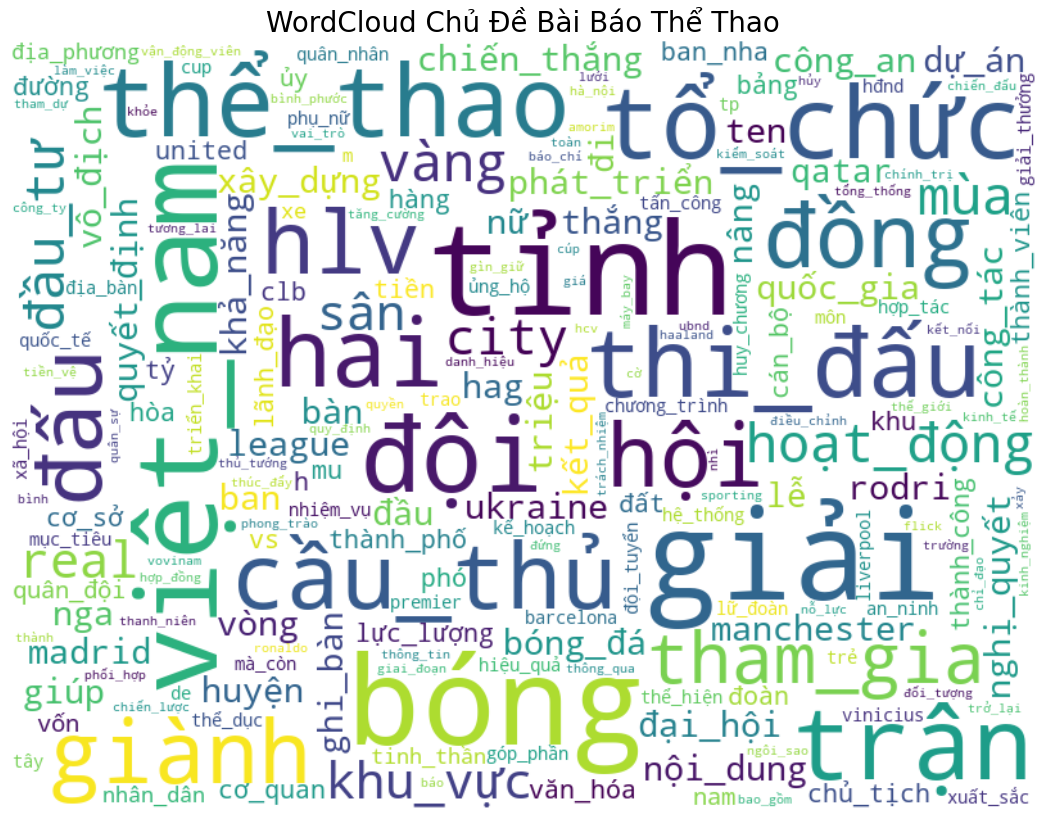

In [81]:
# Tạo WordCloud từ tần suất từ
wordcloud = WordCloud(
    width=800,
    height=600,
    background_color='white',
    max_words=200,
    max_font_size=100,
    min_font_size=10,
    collocations=False
).generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Chủ Đề Bài Báo Thể Thao', fontsize=20)
plt.show()